In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import QFT

### Define components of the algorithm

In [3]:
def initialize_qubits(given_circuit, measurement_qubits, target_qubit):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    given_circuit.h(measurement_qubits)
    given_circuit.x(target_qubit)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

In [4]:
def unitary_operator(given_circuit, control_qubit, target_qubit, theta):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    given_circuit.cu1(2*np.pi*theta, control_qubit, target_qubit)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

In [5]:
def unitary_operator_exponent(given_circuit, control_qubit, target_qubit, theta, exponent):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    given_circuit.cu1(2*np.pi*theta*exponent, control_qubit, target_qubit)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

In [6]:
def apply_iqft(given_circuit, measurement_qubits, n):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    given_circuit.append(QFT(n).inverse(), measurement_qubits)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

### Construct algorithm using components

In [7]:
def qpe_program(n, theta):
    
    # Create a quantum circuit on n+1 qubits (n measurement, 1 target)
    qc = QuantumCircuit(n+1, n)
    
    # Initialize the qubits
    initialize_qubits(qc, range(n), n)
    
    # Apply the controlled unitary operators in sequence
    for x in range(n):
        exponent = 2**(n-x-1)
        unitary_operator_exponent(qc, x, n, theta, exponent)
        
    # Apply the inverse quantum Fourier transform
    apply_iqft(qc, range(n), n)
    
    # Measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

### Execute algorithm on simulator and real hardware with 4 qubits test case

In [8]:
# Define number of qubits and theta value
n = 4; theta = 0.5
test_circuit = qpe_program(n, theta)
test_circuit.draw(output='text')

┌───┐                       ┌───────┐┌─┐         
q_0: ┤ H ├─■─────────────────────┤0      ├┤M├─────────
     ├───┤ │                     │       │└╥┘┌─┐      
q_1: ┤ H ├─┼─────■───────────────┤1      ├─╫─┤M├──────
     ├───┤ │     │               │  iqft │ ║ └╥┘┌─┐   
q_2: ┤ H ├─┼─────┼─────■─────────┤2      ├─╫──╫─┤M├───
     ├───┤ │     │     │         │       │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─┼─────┼─────┼─────■───┤3      ├─╫──╫──╫─┤M├
     ├───┤ │8pi  │4pi  │2pi  │pi └───────┘ ║  ║  ║ └╥┘
q_4: ┤ X ├─■─────■─────■─────■─────────────╫──╫──╫──╫─
     └───┘                                 ║  ║  ║  ║ 
c_0: ══════════════════════════════════════╩══╬══╬══╬═
                                              ║  ║  ║ 
c_1: ═════════════════════════════════════════╩══╬══╬═
                                                 ║  ║ 
c_2: ════════════════════════════════════════════╩══╬═
                                                    ║ 
c_3: ═══════════════════════════════════════════════╩═

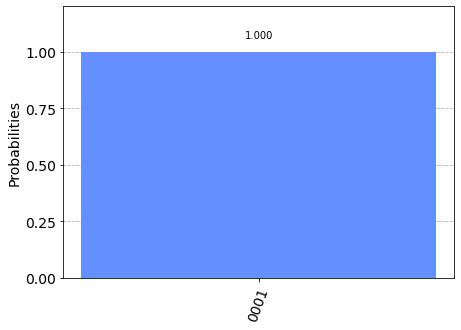

In [9]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(test_circuit, backend=simulator, shots=1000).result().get_counts(test_circuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [10]:
import operator
highest_probability_outcome = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
measured_theta = int(highest_probability_outcome, 2)/2**n
print("Using %d qubits with theta = %.2f, measured_theta = %.2f." % (n, theta, measured_theta))

Using 4 qubits with theta = 0.50, measured_theta = 0.50.


In [11]:
provider = IBMQ.load_account()
device = least_busy(provider.backends(simulator=False))
print("Running on current least busy device: ", device)

from qiskit.tools.monitor import job_monitor
job = execute(test_circuit, backend=device, shots=1000, max_credits=10)
job_monitor(job, interval = 2)

Running on current least busy device:  ibmqx2
Job Status: job has successfully run


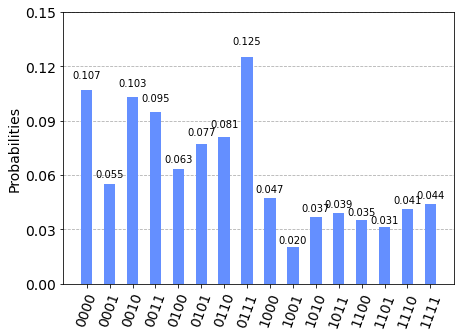

In [12]:
counts = job.result().get_counts()
plot_histogram(counts)